In [19]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from hyperopt import fmin, hp, Trials, STATUS_OK
from hyperopt import atpe
import minisom
from importlib import reload
import SOM_functions as functions
reload(functions)
import warnings
from scipy.spatial import cKDTree
from scipy.stats import pearsonr
from scipy.interpolate import griddata
from scipy.optimize import linear_sum_assignment
np.warnings = warnings

In [14]:
def get_SOM(data_train, zg500_anom, save_path_som='som', save_path_nodes='best_nodes', num_iteration = 100000, optimise=False, plot=False):
    # -------------------------
    # 1. Prepare the weighted data
    # -------------------------
    latitudes = zg500_anom['lat'].values  # Extract latitude array
    latitudes_stacked = np.repeat(latitudes, len(zg500_anom['lon']))
    latitudes_expanded = np.tile(latitudes_stacked, (data_train.shape[0], 1))
    lat_weights = np.sqrt(np.cos(np.deg2rad(latitudes_expanded)))
    weighted_data = data_train * lat_weights

    # -------------------------
    # 2. Define SOM grid and input length
    # -------------------------
    x = 1  # columns
    y = 4  # rows
    input_len = weighted_data.shape[1]

    # -------------------------
    # 3. Optimize SOM parameters
    # -------------------------
    if optimise:
        space = {
            'sig': hp.uniform('sig', 0.01, 1.5),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.01)
        }
    
        def optimise_SOM(space):
            sig = space['sig']
            learning_rate = space['learning_rate']
    
            som_tmp = minisom.MiniSom(
                x=x, y=y, input_len=input_len,
                sigma=sig, learning_rate=learning_rate,
                sigma_decay_function='asymptotic_decay',
                decay_function='asymptotic_decay'
            )
            som_tmp.train_random(weighted_data, 5000)
            val = som_tmp.quantization_error(weighted_data)
            return {'loss': val, 'status': STATUS_OK}
    
        trials = Trials()
        best = fmin(fn=optimise_SOM, space=space, algo=atpe.suggest, max_evals=150, trials=trials)
        sigma = best['sig']
        learning_rate = best['learning_rate']
        print(f'Optimal sigma: {sigma}, Optimal learning_rate: {learning_rate}')
    else:
        print('No optimisation')
        sigma = 0.78
        learning_rate = 0.00995

    # -------------------------
    # 4. Train final SOM with optimal parameters
    # -------------------------
    som = functions.train_som(weighted_data, x, y, input_len, sigma, learning_rate, num_iteration)

    # -------------------------
    # 5. Assign each day to best-matching SOM node
    # -------------------------
    best_nodes = np.array([som.winner(row) for row in weighted_data])  # (num_days, 2)
    best_nodes_flat = np.array([i * x + j for i, j in best_nodes])

    # -------------------------
    # 6. Save SOM and best nodes
    # -------------------------
    sigma_str = f"{sigma:.4g}"
    lr_str = f"{learning_rate:.4g}"
    
    with open(f"{save_path_som}_{sigma_str}_{lr_str}.pkl", 'wb') as f:
        pickle.dump(som, f)
    
    np.save(f"{save_path_nodes}_{sigma_str}_{lr_str}.npy", best_nodes_flat)

    # -------------------------
    # 7. Plotting
    # -------------------------
    if plot:
        functions.plot_complex(som, best_nodes_flat, zg500_anom, y)

    return som, best_nodes_flat
    

In [15]:
ERA5_data_train = np.load('ERA5/ERA5_data_train.npy')
ERA5_zg500_anom = xr.open_dataset('ERA5/ERA5_coords.nc')

ERA5_time_array = pd.to_datetime(ERA5_zg500_anom.time.values)
mask = ERA5_time_array.year >= 1950

ERA5_data_train_cropped = ERA5_data_train[mask]
ERA5_zg500_anom_cropped = ERA5_zg500_anom.sel(time=ERA5_time_array[mask])

som, best_nodes = get_SOM(ERA5_data_train_cropped, ERA5_zg500_anom_cropped, 
        save_path_som='SOMs/ERA5_som_1950-2014', save_path_nodes='SOMs/ERA5_best_nodes_1950-2014', 
        num_iteration = 1000000, optimise=True)


100%|██████████| 150/150 [02:57<00:00,  1.18s/trial, best loss: 39447.51252175925]
Optimal sigma: 0.6558082781564115, Optimal learning_rate: 0.00854412071824308
 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 39430.339795997366


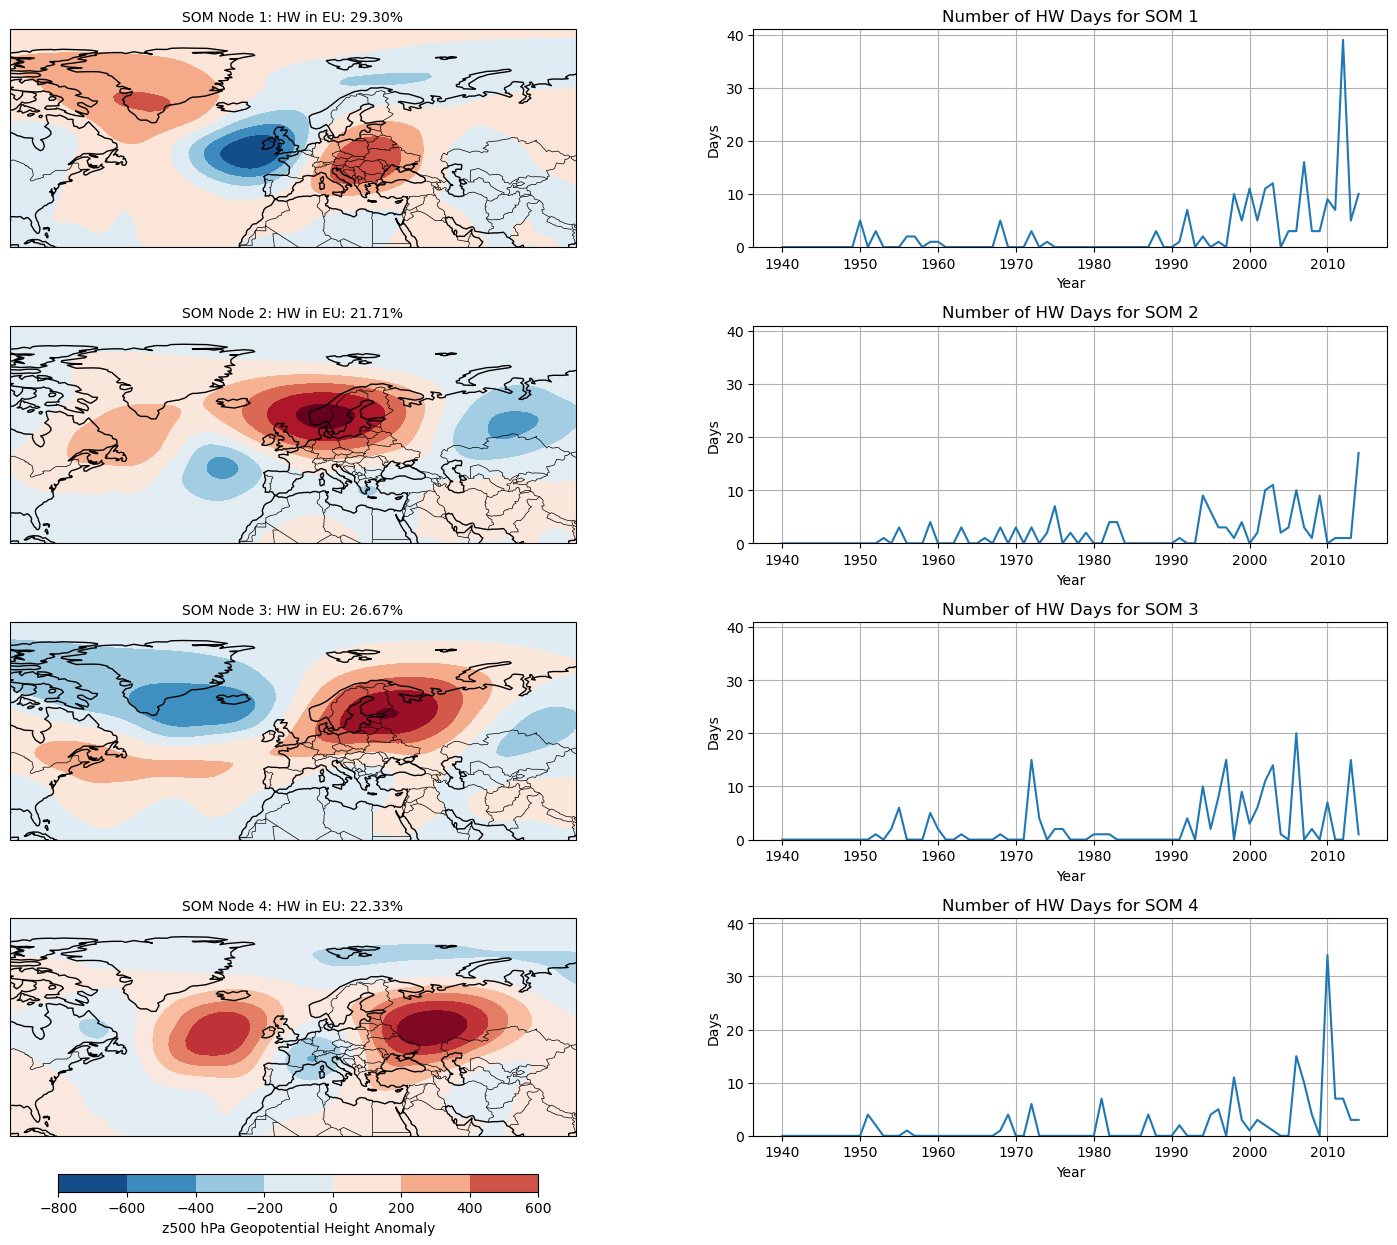

In [18]:
number = '0.6558_0.008544' 
#number = '0.4837874964790536_0.008445744194777737'

som = functions.load_som(f'SOMs/ERA5_som_1950-2014_{number}.pkl')
best_nodes = np.load(f'SOMs/ERA5_best_nodes_1950-2014_{number}.npy')

functions.plot_complex(som, best_nodes, ERA5_zg500_anom_cropped, 4)


In [21]:
exps = ['historical']#['historical', 'hist-GHG', 'hist-aer']
models = ['MIROC6']#['HadGEM3-GC31-LL', 'NorESM2-LM', 'MPI-ESM1-2-LR', 'CanESM5']

for model in models:
    for exp in exps:
        data_train = np.load(f'data_train/{model}_{exp}_data_train.npy')
        zg500_anom = xr.open_dataset(f"data_train/{model}_{exp}coords.nc")
        get_SOM(data_train, zg500_anom, 
                save_path_som=f'SOMs/{model}_{exp}_som', 
                save_path_nodes=f'SOMs/{model}_{exp}_best_nodes', 
                num_iteration = 500000, optimise=True)
        

100%|██████████| 150/150 [26:08<00:00, 10.46s/trial, best loss: 3161.0516015043127]
Optimal sigma: 0.7440325389932279, Optimal learning_rate: 0.009976927973895683
 [  65970 / 500000 ]  13% - 0:00:30 left 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
exp = 'hist-aer' 
model = 'MPI-ESM1-2-LR' #'MPI-ESM1-2-LR' 'CanESM5'

data_train = np.load(f'data_train/{model}_{exp}_data_train.npy')
zg500_anom = xr.open_dataset(f"data_train/{model}_{exp}coords.nc")
som_new = functions.load_som(f'SOMs/MPI-ESM1-2-LR_hist-aer_som_0.78_0.00995.pkl')
best_nodes_flat = np.load('SOMs/MPI-ESM1-2-LR_hist-aer_best_nodes_0.78_0.00995.npy')

ERA5_som = functions.load_som('SOMs/ERA5_som.pkl')
ERA5_best_nodes = np.load('SOMs/ERA5_best_nodes.npy')
ERA5_zg500_anom = xr.open_dataset('ERA5/ERA5_coords.nc')

functions.plot_complex(som_new, best_nodes_flat, zg500_anom, 4)


In [22]:
exps = ['hist-GHG']#['historical', 'hist-GHG', 'hist-aer']
models = ['MIROC6']#['HadGEM3-GC31-LL', 'NorESM2-LM', 'MPI-ESM1-2-LR', 'CanESM5']

for model in models:
    for exp in exps:
        data_train = np.load(f'data_train/{model}_{exp}_data_train.npy')
        zg500_anom = xr.open_dataset(f"data_train/{model}_{exp}coords.nc")
        get_SOM(data_train, zg500_anom, 
                save_path_som=f'SOMs/{model}_{exp}_som', 
                save_path_nodes=f'SOMs/{model}_{exp}_best_nodes', 
                num_iteration = 500000, optimise=True)

100%|██████████| 150/150 [09:00<00:00,  3.61s/trial, best loss: 3141.2202083463435]
Optimal sigma: 0.6653859913981951, Optimal learning_rate: 0.008296283837505396
 [  65563 / 500000 ]  13% - 0:00:30 left 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

